In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import numpy as np
from torch import nn
from modules import ISAB, PMA, SAB
import random

In [16]:
# read training data from a file
fileNum = 8

# match particle ID with charge
particleChargeDict = {2212:1,-2212:-1,2112:0,-2112:0,211:1,-211:-1,111:0,321:1,-321:-1,130:0,11:-1,-11:1,13:-1,-13:1,15:-1,-15:1,22:0}

# each jet is a sequence of vectors, and each vector represents a constituent particle
# vector shape: [px,py,pz,E,charge]
# sequence shape(x): [[px,py,pz,E,charge],[px,py,pz,E,charge],[px,py,pz,E,charge],...]
# flavor label(y): [1](charm/bottom) or [0](light)
# the number of constituent is not fixed, so the sequence length will change

# list of sequences for building Dataset
jetSetData_x_list_training = []
jetSetData_y_list_training = []

nHeavy = 0
nLight = 0

iii=0
for i_file in range(fileNum):
    lineNo = 0
    filePath = "./simulationData/" + "trainingData" + str(i_file+1) + ".txt"
    dataFile = open(filePath)
    print("begin",filePath)
    while True: # jets loop
        jetSequence_list = []
        jetFlavor = torch.zeros(1)

        dataFileLine = dataFile.readline()
        if dataFileLine == '':
            break
        lineNo += 1
        dataFileLine = dataFileLine.strip()
        lineNums = dataFileLine.split()
        constituentNum = int(lineNums[0])
        quarkID = int(lineNums[1])
        if abs(quarkID)==4 or abs(quarkID)==5 or abs(quarkID)==6:
            jetFlavor[0] = 1
        else:
            jetFlavor[0] = 0
        for i in range(constituentNum): # constituents loop
                dataFileLine = dataFile.readline()
                lineNo += 1
                dataFileLine = dataFileLine.strip()
                lineNums = dataFileLine.split()
                particleVector = torch.zeros(5)
                constituentID = int(lineNums[1])
                particleVector[0] = constituentPx = float(lineNums[2])
                particleVector[1] = constituentPy = float(lineNums[3])
                particleVector[2] = constituentPz = float(lineNums[4])
                particleVector[3] = constituentE  = float(lineNums[5])
                particleVector[4] = particleChargeDict[constituentID]
                #particleVector[5] = constituentE  = float(lineNums[6])
                #particleVector[6] = constituentE  = float(lineNums[7])
                #particleVector[7] = constituentE  = float(lineNums[8])
                #particleVector[8] = constituentE  = float(lineNums[9])
                jetSequence_list.append(particleVector)
                
        #if jetFlavor[0] == 1:
           # for i in range(len(jetSequence_list)):
                #jetSequence_list[i][0] = 500
        jetSequence = torch.stack(jetSequence_list, dim=0)

        if jetFlavor[0] == 0:
            p = random.random()
            if p<0.2:
                jetSetData_x_list_training.append(jetSequence.float().unsqueeze(0)) # save each input sequence
                jetSetData_y_list_training.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
                nLight += 1
        elif jetFlavor[0] == 1:
            jetSetData_x_list_training.append(jetSequence.float().unsqueeze(0)) # save each input sequence
            jetSetData_y_list_training.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
            nHeavy += 1
        iii+=1
        if iii%10000==0:
            print("Reading:",iii)
            print(lineNo)
        if iii%10000000==0:
            break
    dataFile.close()

#jetSetData_x_training = torch.stack(jetSetData_x_list, dim=0)
#jetSetData_y_training = torch.stack(jetSetData_y_list, dim=0)
print(jetSetData_x_list_training[0],jetSetData_x_list_training[1],jetSetData_x_list_training[2])
print(jetSetData_y_list_training[0],jetSetData_y_list_training[1],jetSetData_y_list_training[2])
print(nLight,nHeavy)

begin ./simulationData/trainingData1.txt
Reading: 10000
99492
Reading: 20000
199487
Reading: 30000
299342
Reading: 40000
399109
Reading: 50000
498659
Reading: 60000
598107
Reading: 70000
698484
begin ./simulationData/trainingData2.txt
Reading: 80000
21275
Reading: 90000
120868
Reading: 100000
220360
Reading: 110000
319661
Reading: 120000
419477
Reading: 130000
519010
Reading: 140000
618716
Reading: 150000
718505
begin ./simulationData/trainingData3.txt
Reading: 160000
41225
Reading: 170000
140952
Reading: 180000
240567
Reading: 190000
340379
Reading: 200000
439734
Reading: 210000
539856
Reading: 220000
639547
Reading: 230000
738998
begin ./simulationData/trainingData4.txt
Reading: 240000
59539
Reading: 250000
159412
Reading: 260000
259030
Reading: 270000
359021
Reading: 280000
458692
Reading: 290000
558829
Reading: 300000
658334
Reading: 310000
758530
begin ./simulationData/trainingData5.txt
Reading: 320000
79550
Reading: 330000
179667
Reading: 340000
279690
Reading: 350000
379752
Read

In [17]:
jetSetData_list_training = list(zip(jetSetData_x_list_training, jetSetData_y_list_training))
print(len(jetSetData_list_training))

374654


In [103]:
# read cross-validation data from a file
dataFile = open("./simulationdata/testingData.txt")

# list of sequences for building Dataset
jetSetData_x_list_validation = []
jetSetData_y_list_validation = []

iii=0
nLight = 0
nHeavy = 0
while True: # jets loop
    jetSequence_list = []
    jetFlavor = torch.zeros(1)
    dataFileLine = dataFile.readline()
    if dataFileLine == '':
            break
    dataFileLine = dataFileLine.strip()
    lineNums = dataFileLine.split()
    constituentNum = int(lineNums[0])
    quarkID = int(lineNums[1])
    if abs(quarkID)==4 or abs(quarkID)==5 or abs(quarkID)==6:
        jetFlavor[0] = 1
    else:
        jetFlavor[0] = 0
    for i in range(constituentNum): # constituents loop
            dataFileLine = dataFile.readline()
            dataFileLine = dataFileLine.strip()
            lineNums = dataFileLine.split()
            particleVector = torch.zeros(5)
            constituentID = int(lineNums[1])
            particleVector[0] = constituentPx = float(lineNums[2])
            particleVector[1] = constituentPy = float(lineNums[3])
            particleVector[2] = constituentPz = float(lineNums[4])
            particleVector[3] = constituentE  = float(lineNums[5])
            particleVector[4] = particleChargeDict[constituentID]
            #particleVector[5] = constituentE  = float(lineNums[6])
            #particleVector[6] = constituentE  = float(lineNums[7])
            #particleVector[7] = constituentE  = float(lineNums[8])
            #particleVector[8] = constituentE  = float(lineNums[9])
            jetSequence_list.append(particleVector)
    #if jetFlavor[0] == 1:
        #for i in range(len(jetSequence_list)):
            #jetSequence_list[i][0] = 500
    
    jetSequence = torch.stack(jetSequence_list, dim=0)

    #jetSetData_x_list_validation.append(jetSequence.float().unsqueeze(0)) # save each input sequence
    #jetSetData_y_list_validation.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
    
    if jetFlavor[0] == 0:
        p = random.random()
        if p<0.2:
            jetSetData_x_list_validation.append(jetSequence.float().unsqueeze(0)) # save each input sequence
            jetSetData_y_list_validation.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
            nLight += 1
    elif jetFlavor[0] == 1:
        jetSetData_x_list_validation.append(jetSequence.float().unsqueeze(0)) # save each input sequence
        jetSetData_y_list_validation.append(jetFlavor.float().unsqueeze(0).unsqueeze(0)) # save each output label
        nHeavy += 1
    
    iii+=1
    if iii%10000==0:
        print("Reading:",iii)
    if iii%100000==0:
        break
dataFile.close()

#jetSetData_x_training = torch.stack(jetSetData_x_list, dim=0)
#jetSetData_y_training = torch.stack(jetSetData_y_list, dim=0)
print(jetSetData_x_list_validation[0],jetSetData_x_list_validation[1],jetSetData_x_list_validation[2])
print(jetSetData_y_list_validation[0],jetSetData_y_list_validation[1],jetSetData_y_list_validation[2])
print(nLight,nHeavy)

Reading: 10000
Reading: 20000
Reading: 30000
Reading: 40000
Reading: 50000
Reading: 60000
Reading: 70000
Reading: 80000
Reading: 90000
Reading: 100000
tensor([[[ 0.1243,  0.0994,  0.9808,  1.1095,  1.0000],
         [ 0.3482,  0.2712,  1.2604,  1.3354,  0.0000],
         [ 0.5335,  0.1593,  0.7860,  0.9632,  0.0000],
         [ 0.3578,  0.1742,  0.7413,  0.8413,  0.0000],
         [ 0.7035, -0.3186,  1.7156,  1.8866,  1.0000],
         [ 1.4916,  0.1236,  4.9541,  5.1988,  1.0000],
         [ 1.8094, -0.0220,  5.3108,  5.6322, -1.0000]]]) tensor([[[-0.2376, -0.0532, -0.1695,  0.2967,  0.0000],
         [-0.3509, -0.0163, -0.4312,  0.5734,  1.0000],
         [-0.8005, -0.0722, -0.8406,  1.2650,  0.0000],
         [-0.3330,  0.0210, -0.4063,  0.5257,  0.0000],
         [-0.3909,  0.1343, -0.3779,  0.5772, -1.0000],
         [-0.7623,  0.4317, -0.7749,  1.1779,  1.0000],
         [-2.0389,  1.2059, -1.5166,  2.8162, -1.0000]]]) tensor([[[ 1.9124e-01,  1.4191e-01,  2.9792e-01,  4.0614e-01,

In [105]:
jetSetData_list_validation = list(zip(jetSetData_x_list_validation, jetSetData_y_list_validation))

In [54]:
# construct the model
class SetTransformer(nn.Module):
    def __init__(
        self,
        dim_input=9,
        num_outputs=1,
        dim_output=1,
        num_inds=32,
        dim_hidden1=128,
        dim_hidden2=64,
        dim_hidden3=16,
        num_heads=4,
        ln=False,
    ):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
            ISAB(dim_input, dim_hidden1, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden1, dim_hidden1, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden1, dim_hidden1, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden1, dim_hidden1, num_heads, num_inds, ln=ln),
        )
        self.dec = nn.Sequential(
            nn.Dropout(),
            PMA(dim_hidden1, num_heads, num_outputs, ln=ln),
            nn.Dropout(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.ReLU(dim_hidden2),
            nn.Linear(dim_hidden2, dim_hidden3),
            nn.ReLU(dim_hidden3),
            nn.Linear(dim_hidden3, dim_output),
        )

    def forward(self, X):
        return self.dec(self.enc(X))

In [55]:
# a function to calculate accuracy, precision and recall rate
def modelEval(TP,FN,FP,TN):
    if (TP + FN + FP + TN) != 0:
        accuracy = (TP + TN)/(TP + FN + FP + TN)
    else:
        accuracy = -1
    if (TP + FP) != 0:
        precision = (TP)/(TP + FP)
    else:
        precision = -1
    if (TP + FN) != 0:
        recall = (TP)/(TP + FN)
    else:
        recall = -1
    return accuracy,precision,recall

In [56]:
# definition of hyper-parameters
# model
dim_input=5
dim_output=1
num_inds=32
dim_hidden1=128
dim_hidden2=64
dim_hidden3=16
num_heads=4

# for optimizer
learning_rate = 0.01
lr = 0.0005
momentum = 0.5
lambd = 0.001 # regularization
accum_steps=32

In [57]:
# GPU acceleration
device = torch.device("cuda:0")
# model instance
jetClassification = SetTransformer(dim_input=dim_input, 
                                   dim_hidden1=dim_hidden1, 
                                   dim_hidden2=dim_hidden2,
                                   dim_hidden3=dim_hidden3,
                                   dim_output=dim_output, 
                                   num_heads=num_heads, 
                                   num_inds=num_inds)
jetClassification.to(device)
save_dir = './modelsave/setTransformer.pt'
#jetClassification = torch.load(save_dir)
jetClassification.to(device)
# loss function: BCEWithLogitsLoss
pos_weight = torch.tensor ([13.96]) 
pos_weight = pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
# optimizer = Adam
opt_Adam = torch.optim.Adam(jetClassification.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=lambd)
opt_SGD = torch.optim.SGD(jetClassification.parameters(), lr=lr, momentum=momentum, nesterov=True)

In [58]:
loss_list_train = []
loss_list_test = []

In [106]:
num_epoches = 100
for epoch in range(num_epoches):
    jetClassification.train()
    train_loss=0
    train_TP=0 # True:1 Pred:1
    train_FN=0 # True:1 Pred:0
    train_FP=0 # True:0 Pred:1
    train_TN=0 # True:0 Pred:0
    batchNum = 0
    random.shuffle(jetSetData_list_training)
    random.shuffle(jetSetData_list_validation)
    for i_item in range(len(jetSetData_x_list_training)):
        jetSequence,jetLabel = jetSetData_list_training[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        out = jetClassification(jetSequence)
        loss = criterion(out,jetLabel)
        # backward propagation
        loss.backward()
        if i_item % accum_steps == 0 or (i_item+1)==len(jetSetData_x_list_training):
            opt_Adam.step()
            opt_Adam.zero_grad()
            batchNum+=1
            if batchNum%200==0:
                print("batchNum: ",batchNum)
                train_accuracy,train_precision,train_recall = modelEval(train_TP,train_FN,train_FP,train_TN)
                print('   train_accuracy:{:.4f}  train_precision:{:.4f}  train_recall:{:.4f}  train_loss:{:.4f}'
         .format(train_accuracy,train_precision,train_recall,train_loss))
        train_loss += loss.item()
        # data to evaluate the model
        if out[0][0]>0 and jetLabel[0][0]==1:
            train_TP += 1 
        if out[0][0]<0 and jetLabel[0][0]==1:
            train_FN += 1 
        if out[0][0]>0 and jetLabel[0][0]==0:
            train_FP += 1 
        if out[0][0]<0 and jetLabel[0][0]==0:
            train_TN += 1 
        if(i_item>100):
            break
    # performance on training set
    train_accuracy,train_precision,train_recall = modelEval(train_TP,train_FN,train_FP,train_TN)
    print('epoch:{}  train_accuracy:{:.4f}  train_precision:{:.4f}  train_recall:{:.4f}  train_loss:{:.4f}'
         .format(epoch,train_accuracy,train_precision,train_recall,train_loss))
    loss_list_train.append(train_loss)
    # performance on testing set
    jetClassification.eval()
    test_TP=0 # True:1 Pred:1
    test_FN=0 # True:1 Pred:0
    test_FP=0 # True:0 Pred:1
    test_TN=0 # True:0 Pred:0
    for i_item in range(len(jetSetData_x_list_validation)):
        jetSequence,jetLabel = jetSetData_list_validation[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        out = jetClassification(jetSequence)
        loss = criterion(out, jetLabel)
        # data to evaluate the model
        if out[0][0]>0 and jetLabel[0][0]==1:
            test_TP += 1 
        if out[0][0]<0 and jetLabel[0][0]==1:
            test_FN += 1 
        if out[0][0]>0 and jetLabel[0][0]==0:
            test_FP += 1 
        if out[0][0]<0 and jetLabel[0][0]==0:
            test_TN += 1 
        if(i_item>10000):
            break
    test_accuracy,test_precision,test_recall = modelEval(test_TP,test_FN,test_FP,test_TN)
    print('         test_accuracy:{:.4f}   test_precision:{:.4f}    test_recall:{:.4f}'
         .format(test_accuracy,test_precision,test_recall))


epoch:0  train_accuracy:0.2059  train_precision:0.0476  train_recall:0.8000  train_loss:119.2524
         test_accuracy:0.3203   test_precision:0.0789    test_recall:0.8218
epoch:1  train_accuracy:0.4020  train_precision:0.1029  train_recall:1.0000  train_loss:126.7694


KeyboardInterrupt: 

In [108]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
random.shuffle(jetSetData_list_training)
random.shuffle(jetSetData_list_validation)
y_true=[]
y_pred=[]
for i_item in range(len(jetSetData_x_list_training)):
        jetSequence,jetLabel = jetSetData_list_training[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        with torch.no_grad():
            out = jetClassification(jetSequence)
            out = F.sigmoid(out)
            y_pred.append(float(out[0][0][0]))
            y_true.append(float(jetLabel[0][0][0]))
        if i_item > 10000:
            break

In [109]:
#jetClassification = torch.load(save_dir)
y_true_test=[]
y_pred_test=[]
for i_item in range(len(jetSetData_x_list_validation)):
        jetSequence,jetLabel = jetSetData_list_validation[i_item]
        jetSequence = jetSequence.to(device)
        jetLabel = jetLabel.to(device)
        # forward propagation
        with torch.no_grad():
            out = jetClassification(jetSequence)
            out = F.sigmoid(out)
            #print(jetLabel)
            #print(out)
            y_pred_test.append(float(out[0][0][0]))
            y_true_test.append(float(jetLabel[0][0][0]))
        if i_item > 10000:
            break

374654
AUC in training set: 0.5716930616516168
AUC in validation set: 0.5843295794223115


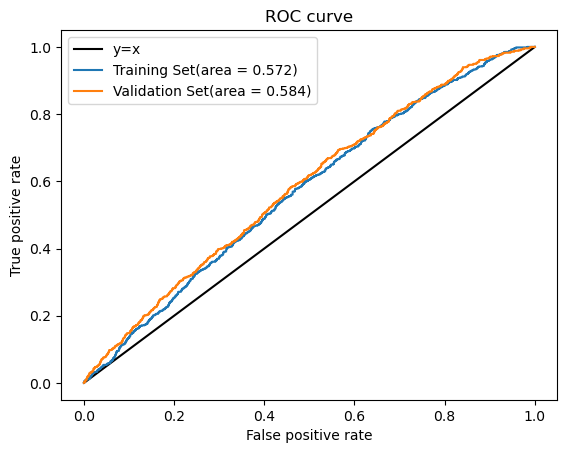

In [110]:
%matplotlib inline
print(len(jetSetData_x_list_training))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print("AUC in training set:",roc_auc)

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_true_test, y_pred_test)
roc_auc_test = roc_auc_score(y_true_test, y_pred_test)
print("AUC in validation set:",roc_auc_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-', label = 'y=x')
plt.plot(fpr, tpr, label='Training Set(area = {:.3f})'.format(roc_auc))
plt.plot(fpr_test, tpr_test, label='Validation Set(area = {:.3f})'.format(roc_auc_test))
plt.xlabel('False positive rate')
plt.ylabel("True positive rate")
plt.title('ROC curve')
plt.legend()
plt.show()

In [78]:
save_dir = './modelsave/setTransformer_vertex.pt'   #保存路径

# 保存+读取整个模型
torch.save(jetClassification, save_dir)
loaded_model = torch.load(save_dir)
loaded_model.cuda()

SetTransformer(
  (enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=9, out_features=128, bias=True)
        (fc_v): Linear(in_features=9, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=9, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
     

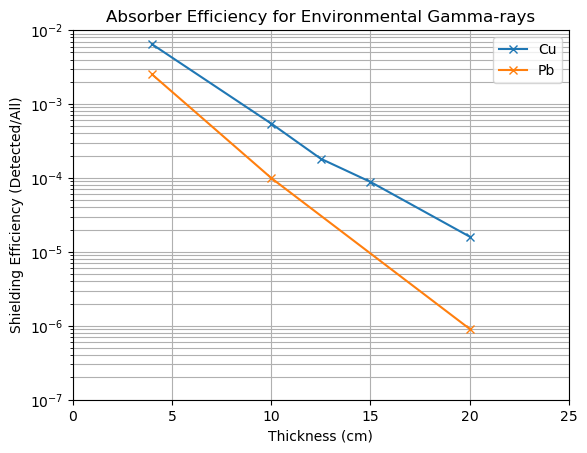

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.yscale("log")
x_cu=[4,10,12.5,15,20]
y_cu=[642752/1e8,54500/1e8,18193/1e8,8854/1e8,1610/1e8]
x_pb=[4,10,20]
y_pb=[251119/1e8,9997/1e8,91/1e8]
plt.plot(x_cu,y_cu, label = 'Cu',marker='x')
plt.plot(x_pb,y_pb, label = 'Pb',marker='x')
plt.xlabel('Thickness (cm)')
plt.ylabel("Shielding Efficiency (Detected/All)")
plt.title('Absorber Efficiency for Environmental Gamma-rays')
plt.xlim(0, 25)
plt.ylim(1e-7,1e-2)
plt.grid(visible=None, which='major', axis='both')
plt.grid(visible=None, which='minor', axis='both')
plt.legend()
plt.show()

